# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [279]:
import warnings

import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

warnings.filterwarnings("ignore")

In [280]:
df = pd.read_csv('./tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
20096,28302,73254,Norfolk,26-03-2020,"Look out for the scammers. New websites, no wa...",Negative
14740,21724,66676,"Cleveland, OH",23-03-2020,"DonÃÂt say anything. Just watch, laugh and R...",Positive
14315,21179,66131,"Tampa, FL",23-03-2020,When the store is out of courtesy sanitizing w...,Positive
12594,19066,64018,NaN,22-03-2020,Great work from ?@Morrisons?! TheyÃÂve becom...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [281]:
# было
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive


In [282]:
df["Sentiment"] = np.where(df["Sentiment"].str.contains("[Pp]ositive"), 1, 0)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [283]:
sentiment_vc = df["Sentiment"].value_counts()
sentiment_vc

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [284]:
dif = np.abs(sentiment_vc.iloc[0] - sentiment_vc.iloc[1]) / np.max([sentiment_vc.iloc[0], sentiment_vc.iloc[1]])
np.round(100 * dif, 2)

14.67

**Ответ:** разница в $\thicksim$15% приемлема для принятия отношения
классов за сбалансированные

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [285]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Нет данных про локацию, заменим все пустой строкой `unknown`

In [286]:
df["Location"] = df["Location"].fillna("unknown")
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [287]:
from sklearn.model_selection import train_test_split

y = df["Sentiment"]
X = df.drop(["Sentiment"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [288]:
words_data = {}

def add_to_words(text_sample):
    words = map(lambda x: x.lower(), text_sample.split())
    for w in words:
        words_data[w] = words_data.get(w, 0) + 1
        
X_train["OriginalTweet"].apply(add_to_words)

25621    None
30135    None
28899    None
5989     None
4367     None
         ... 
20757    None
32103    None
30403    None
21243    None
2732     None
Name: OriginalTweet, Length: 23410, dtype: object

Какой размер словаря получился?

In [289]:
len(words_data)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [290]:
words_data_s = pd.Series(words_data)
words_data_s = words_data_s.sort_values(ascending=False)
words_data_s.head(10)

the             26815
to              23373
and             14684
of              13012
a               11737
in              11198
for              8566
#coronavirus     8223
is               7383
are              7050
dtype: int64

**Ответ:** Стоп-слова. Стоит заметить, что эти слова не склоняются, и потому их может 
быть больше, чем, например, склоняемых слов.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [291]:
import nltk
from nltk.corpus import stopwords

st_w = stopwords.words("english")

new_index_bool = ~np.in1d(words_data_s.index, st_w)
new_index = words_data_s.index[new_index_bool]

words_data_no_stopwords = words_data_s.reindex(new_index)

words_data_no_stopwords.head(10)

#coronavirus    8223
prices          3891
food            3820
grocery         3469
supermarket     3288
people          3175
covid-19        3173
store           3155
#covid19        2471
&amp;           2314
dtype: int64

**Ответ:** кроме, собственно, ковида, обсуждается функционирование магазинов 
и цен: сама основа быта каждого человека. Очевидный вывод: ковид консулся человека настолько плотно, что основные темы для обсуждения - самые низовые потребности, такие как купить покушать.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [292]:
words_data_no_stopwords.tail(20)

pmt                        1
acres                      1
cucumber                   1
https://t.co/x69jqbisox    1
had!                       1
#springcleaning            1
https://t.co/l8jnzxjgwo    1
contained,                 1
readiness,                 1
kick-in                    1
(covid-19,                 1
impacts)                   1
https://t.co/wa7kcdwqea    1
@linkedin                  1
clare                      1
connors                    1
levins                     1
587-4272                   1
https://t.co/6ytxpz5ug9    1
https://t.co/7j2y3rsld9    1
dtype: int64

**Ответ:** работать с этими токенами не получится, но это не говорит, что, например, 
токен `prohibitions` (который в топ-20 самых редких) ни о чем не может нам сказать. Просто обработка текста путем сплита по пробелам может дать очень грубые усреднения, на которые можно ориентироваться, только когда ничего другого нет. Этим и займемся..



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [293]:
from nltk.tokenize import TweetTokenizer
from string import punctuation

tokens = {}
tokenizer = TweetTokenizer()

st_l = st_w + list(punctuation)

def parse_tokens(text_sample):
    ts = tokenizer.tokenize(text_sample)
    for t in ts:
        t = t.lower().strip()
        if len(t) == 1 and ord(t) >= 128:
            continue
        if t not in st_l:
            tokens[t] = tokens.get(t, 0) + 1

X_train["OriginalTweet"].apply(parse_tokens)

tokens = pd.Series(tokens).sort_values(ascending=False)
tokens.head(10)

#coronavirus    8808
19              7167
covid           6253
prices          4601
food            4367
store           3877
supermarket     3805
grocery         3523
people          3463
#covid19        2589
dtype: int64

**Ответ:** в целом, усреднение по сплиту оказалось полезнее, чем можно было предположить.
Топ значений сохранился, как и интерпретация всего этого дела.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [294]:
from string import punctuation

# -- YOUR CODE HERE --

**Ответ:** упс, уже сделал

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [295]:
tokens.tail(20)

@awgcorporate              1
https://t.co/l8jnzxjgwo    1
587-4272                   1
readiness                  1
kick-in                    1
https://t.co/wa7kcdwqea    1
@linkedin                  1
clare                      1
connors                    1
levins                     1
https://t.co/6ytxpz5ug9    1
https://t.co/8xikga3rel    1
quantitatively             1
logarithmic                1
non-log                    1
improveã                   1
https://t.co/aacxqg5sej    1
rebooked                   1
can't-miss                 1
https://t.co/7j2y3rsld9    1
dtype: int64

**Ответ:**

Изначально я захардкодил пару неинформативных символов, добавив в стоп-лист, но увидев этот пункт изменил решение.

Говоря о репрезентативности: топ остался тот же (или почти тот же, но новых выводов сделать нельзя), однако хвост оказался более репрезентативен. Несмотря на теги, ссылки и прочий смысловой мусор, о каких-то токенах мы можем рассуждать как о непопулярных, например, `wrinkles`, `ombudsman` 

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [296]:
hashtag_pattern = r'^#.+'

hashtags_bool = tokens.index.str.match(hashtag_pattern)
hashtags_index = tokens.index[hashtags_bool]

hashtags = tokens.reindex(hashtags_index)
hashtags.head(20)

#coronavirus            8808
#covid19                2589
#covid_19               1734
#covid2019               946
#toiletpaper             744
#covid                   641
#socialdistancing        465
#coronacrisis            448
#pandemic                257
#coronaviruspandemic     249
#stayhome                235
#coronavirusoutbreak     223
#covid-19                218
#corona                  209
#lockdown                208
#supermarket             206
#stayathome              197
#panicbuying             197
#stayhomesavelives       194
#stophoarding            190
dtype: int64

**Ответ:** 

Выводы похожи на вывод для всех токенов, но с оговоркой. Кроме упоминаний базоых нужд, таких как туалетная бумага и магазины, можно заметить, что хештеги подсвечивают посыл, идею и внутренную ценность автора. Например, `stayhome`, `stayhomesavelives`, `socialdistancing` - явные призывы к действую. Возможно, имеет смысл удеелить хештегам больше внимания при обучении модели.

*выбрал топ-20 для большей репрезентативности*

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [297]:
url_pattern = r'^https://t\.co'

url_bool = tokens.index.str.match(url_pattern)
url_index = tokens.index[url_bool]

links = tokens.reindex(url_index)
links.head(20)

https://t.co/oxa7swtond       5
https://t.co/gp3eusapl8       4
https://t.co/g63rp042ho       3
https://t.co/3gbbdpdjat       3
https://t.co/e2znxajpre       3
https://t.co/catkegayoy       3
https://t.co/zjnrx6dkkn       3
https://t.co/wrlhyzizaa       3
https://t.co/bylqxrjmnt       3
https://t.co/oi39zsanq8       3
https://t.co/wuieefsnoj       3
https://t.co/kuwipf1kqw       3
https://t.co/aziqcdgrnn       3
https://t.co/deftrui1pfãâ    3
https://t.co/idrwmv5xvd       2
https://t.co/flsrsnlmwu       2
https://t.co/ealrmfwnxg       2
https://t.co/drfyfx7ths       2
https://t.co/n4fznmmsh7       2
https://t.co/i7uiizconb       2
dtype: int64

**Ответ:** самая популярная ссылка имеет 5 твитов с ней, что очень мало. Так что нет, ссылки
для анализа не принесут ничего полезного, так как малое количесво данных не может позволить сделать какие-то знаяимые связи.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [298]:
# не думал не гадал, но уже почти написал его выше

from nltk.tokenize import TweetTokenizer
from string import punctuation
import re

tokenizer = TweetTokenizer()

st_l = st_w + list(punctuation)

def custom_tokenizer(text):
    tokens = []
    ts = tokenizer.tokenize(text)
    
    for t in ts:
        t = t.lower().strip()
        
        if len(t) == 1 and ord(t) >= 128:
            continue
        if len(re.findall(url_pattern, t)) > 0:
            continue
        if t in st_l:
            continue

        tokens.append(t)

    return tokens


In [299]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [300]:
X_train.shape

(23410, 5)

In [301]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit_transform(X_train["OriginalTweet"])

print(len(cv.vocabulary_))

45290


**Ответ:** # -- YOUR ANSWER HERE --

было: 45308

Посмотрим на какой-нибудь конкретный твитт:

In [302]:
ind = 9023
df.iloc[ind]['OriginalTweet'], df.iloc[ind]['Sentiment']

("Shop keepers taking advantage of #Coronavirus boosting prices disproportionately so the most Marginalised suffer who can't afford it #SHAMEONYOU #Wewillremember",
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [303]:
arr = cv.transform([df.iloc[ind]['OriginalTweet']]).toarray()
bof = pd.Series(arr.reshape(-1), index=cv.get_feature_names_out())
bof = bof.sort_values(ascending=False)
bof.head(20)

#wewillremember       1
can't                 1
shop                  1
afford                1
disproportionately    1
#coronavirus          1
boosting              1
prices                1
#shameonyou           1
suffer                1
taking                1
marginalised          1
keepers               1
advantage             1
interest              0
interactions          0
intereste             0
interesed             0
interested            0
interesting           0
dtype: int64

**Ответ:** самых важных слово в тексте - 11, ровно столько в нем токенов.
То есть каждое слово имеет одинаковый вес в данном представлении. То есть мы не смогли отпределить самого важногог токена.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [304]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_vec.fit(X_train["OriginalTweet"])

ans = tfidf_vec.transform([df.iloc[ind]['OriginalTweet']]).toarray()

needed_indexes = custom_tokenizer(df.iloc[ind]['OriginalTweet'])

sample_v = pd.Series(ans.reshape(-1), index=tfidf_vec.get_feature_names_out())
sample_v = sample_v.reindex(needed_indexes)
sample_v = sample_v.sort_values(ascending=False)
sample_v.head(20)

marginalised          0.373460
#wewillremember       0.373460
#shameonyou           0.348492
keepers               0.333887
disproportionately    0.328334
boosting              0.306035
suffer                0.266462
afford                0.230787
advantage             0.211172
can't                 0.196633
taking                0.187111
shop                  0.172201
prices                0.096845
#coronavirus          0.071426
dtype: float64

**Ответ:**

Маргинализировать в самом деле обычно имеет негативную окраску как что-то непопулярное и отталкивающие массы. Так что браво! Да и весь топ-3 (который очень похож по важности) сильно передает негативную окраску текстов. 

И последнему месту браво не меньше, ведь коронавирус упоминаются в таком большом количестве твитов, что на этот токен не имеет смысла ориентироваться.

-------------

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [305]:
idx = 33169

# в предложении есть слово "hope"
sample = df.iloc[idx]
sample["OriginalTweet"]

"On the way home, I wanted to stop by a grocery store for a few items but I didn't. It can wait. I hope my decision today saved a life or two! #DidntDoList #StayHomeSaveLives"

In [306]:
needed_indexes = custom_tokenizer(df.iloc[idx]['OriginalTweet'])

ans = tfidf_vec.transform([df.iloc[idx]['OriginalTweet']]).toarray()

sample_v = pd.Series(ans.reshape(-1), index=tfidf_vec.get_feature_names_out())
sample_v = sample_v.reindex(needed_indexes)
sample_v = sample_v.sort_values(ascending=False)
sample_v.head(20)

#didntdolist          0.444128
saved                 0.343401
decision              0.315799
wanted                0.282513
wait                  0.262441
#stayhomesavelives    0.247940
hope                  0.233841
life                  0.229202
two                   0.224887
items                 0.207433
way                   0.204947
stop                  0.192462
today                 0.188281
home                  0.169852
grocery               0.125894
store                 0.122157
dtype: float64

**Ответ:** Сравнивая мое предположительный токен: `hope`, и токен, выделенный
алгоритмом, я склоняюсь к его версии! `saved` сразу навеевает позитив на сообщение. А что значит `#didntdolist` я так и не понял 

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [307]:
simple_cv_train = cv.transform(X_train['OriginalTweet'])
tfidf_vc_train = tfidf_vec.transform(X_train['OriginalTweet'])

simple_cv_test = cv.transform(X_test['OriginalTweet'])
tfidf_vc_test = tfidf_vec.transform(X_test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [308]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_simple = LogisticRegression()
lr_tfidf = LogisticRegression()

lr_simple.fit(simple_cv_train, y_train)
lr_tfidf.fit(tfidf_vc_train, y_train)

simple_cv_train_pred = lr_simple.predict(simple_cv_train)
tfidf_cv_train_pred = lr_tfidf.predict(tfidf_vc_train)

simple_cv_test_pred = lr_simple.predict(simple_cv_test)
tfidf_cv_test_pred = lr_tfidf.predict(tfidf_vc_test)

data_accuracy = {
    "count_train": accuracy_score(simple_cv_train_pred, y_train),
    "count_test": accuracy_score(simple_cv_test_pred, y_test),
    "tfidf_train": accuracy_score(tfidf_cv_train_pred, y_train),
    "tfidf_test": accuracy_score(tfidf_cv_test_pred, y_test),
}

pd.Series(data_accuracy)

count_train    0.984665
count_test     0.867052
tfidf_train    0.922426
tfidf_test     0.852800
dtype: float64

**Ответ:** на наших моделях себя лучше показал логистический регрессор,
и на `test`, и на `train` выборках. Получается, на данном примере себя намного лучше показал вариант векторизации попроще. Интерпретирвоать это сложно, на самом деле, но поптаюсь:

ладно, я не знаю, сдаюсь...

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [309]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
import re

tokenizer = TweetTokenizer()
stemmer = SnowballStemmer("english")
st_l = st_w + list(punctuation)

def custom_stem_tokenizer(text):
    tokens = []
    ts = tokenizer.tokenize(text)
    ts = [stemmer.stem(t) for t in ts]
    
    for t in ts:
        t = t.lower().strip()
        
        if len(t) == 1 and ord(t) >= 128:
            continue
        if len(re.findall(url_pattern, t)) > 0:
            continue
        if t in st_l:
            continue

        tokens.append(t)

    return tokens

In [310]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [311]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(X_train["OriginalTweet"])

print(len(cv.vocabulary_))

36608


**Ответ** Что предсказуемо, словарных запас значительно сохранился, ведь 
функция стемминга от невозрастающая (слов станосится меньше или равно). А так как наш корпус текстов был велик, он уменьшился.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [312]:
count_vc_stemed = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_vc_stemed = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

count_vc_stemed.fit(X_train["OriginalTweet"])
tfidf_vc_stemed.fit(X_train["OriginalTweet"])

count_vc_test = count_vc_stemed.transform(X_test["OriginalTweet"])
count_vc_train = count_vc_stemed.transform(X_train["OriginalTweet"])

tfidf_vc_test = tfidf_vc_stemed.transform(X_test["OriginalTweet"])
tfidf_vc_train = tfidf_vc_stemed.transform(X_train["OriginalTweet"])

In [313]:
lr_count = LogisticRegression()
lr_tfidf = LogisticRegression()

lr_count.fit(count_vc_train, y_train)
lr_tfidf.fit(tfidf_vc_train, y_train)

count_train_pred = lr_count.predict(count_vc_train)
tfidf_train_pred = lr_tfidf.predict(tfidf_vc_train)

count_test_pred = lr_count.predict(count_vc_test)
tfidf_test_pred = lr_tfidf.predict(tfidf_vc_test)

data_stem_accuracy = {
    "count_train": accuracy_score(count_train_pred, y_train),
    "count_test": accuracy_score(count_test_pred, y_test),
    "tfidf_train": accuracy_score(tfidf_train_pred, y_train),
    "tfidf_test": accuracy_score(tfidf_test_pred, y_test),
}

pd.Series(data_stem_accuracy)


count_train    0.971721
count_test     0.868148
tfidf_train    0.915549
tfidf_test     0.854694
dtype: float64

**Ответ:** применив стеминг значения при `CountVectorizer` почти не изменились
(что даже похоже на ошибку, но вроде нет), и `TfidfVectirizer` изменился несущественно: минус процент на обучающей, плюс процент на тестовой. В данно мпримере нет смсла использовать стемминг. Качество моделей меняется несущественно.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [314]:
possible = np.linspace(0.1, 1, 5)
for p in possible:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=p
                        ).fit(
                            X_train["OriginalTweet"]
                            )
    print(len(cv_df.vocabulary_), p)

36596 0.1
36607 0.325
36608 0.55
36608 0.775
36608 1.0


**Ответ:** получается, только 2 слова встречались в более чем 10% текстов,
и только одно в более чем  в 32.5% текстов. Значение в ответ - 0.325, так как оно вычеркивает одно значение из текста.

Это можно интерпретировать так: люди редко используют одни и те же слова (токены) (не считая мусорные stop-words), когда пишут посты.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [315]:
def din_search(l, r, res):
    eps = 1e-10
    while (r - l) > eps:
        mid = (l + r) / 2
        
        cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=mid
                        ).fit(
                            X_train["OriginalTweet"]
                            )
        cur_amount = len(cv_df.vocabulary_)

        print(cur_amount, l, r)

        if cur_amount < res: # то есть слов у нас мало, надо больше слов! надо уменьшить границу
            r = mid
        elif cur_amount == 3700:
            return mid
        else:
            l = mid
        
    return l

In [317]:
din_search(0.0001, 0.1, 3700)

36 0.0001 0.1
107 0.0001 0.050050000000000004
248 0.0001 0.025075000000000004
537 0.0001 0.012587500000000001
975 0.0001 0.00634375
1614 0.0001 0.0032218750000000003
2421 0.0001 0.0016609375
3484 0.0001 0.0008804687500000001
4963 0.0001 0.000490234375
3925 0.0002951171875 0.000490234375
3694 0.00039267578125 0.000490234375
3925 0.00039267578125 0.000441455078125
3694 0.0004170654296875 0.000441455078125
3925 0.0004170654296875 0.00042926025390624997
3925 0.000423162841796875 0.00042926025390624997
3694 0.00042621154785156247 0.00042926025390624997
3925 0.00042621154785156247 0.00042773590087890625
3694 0.00042697372436523433 0.00042773590087890625


KeyboardInterrupt: 

**Ответ:** получатся, четку грань найти сложно, однако число 
`0.0004271679900586605` наиболее подходит под условие задачи.

Интерпретация: всего доли процента достаточно, чтобы отрезать большую часть слов (токенов). То есть слова редко встрнечаются в разных текстах.

In [318]:
min_db_var = 0.0004271679900586605

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [319]:
from sklearn.preprocessing import StandardScaler

count_vc_data = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    min_df=min_db_var
)

train = count_vc_data.fit_transform(X_train["OriginalTweet"])
test = count_vc_data.transform(X_test["OriginalTweet"])

sc = StandardScaler(with_mean=False)
sc.fit(train)
train_normed = sc.transform(train)
test_normed = sc.transform(test)

lr = LogisticRegression()
lr.fit(train_normed, y_train)

train_pred = lr.predict(train_normed)
test_pred = lr.predict(test_normed)

accuracy = {
    "train": accuracy_score(train_pred, y_train),
    "test": accuracy_score(test_pred, y_test)
}

data_ans = pd.Series(accuracy)
data_ans

train    0.941521
test     0.843731
dtype: float64

In [320]:
tokens_weigth = pd.Series(
    data=lr.coef_[0],
    index=count_vc_data.get_feature_names_out()
)
tokens_weigth = tokens_weigth.sort_values()
tokens_weigth

crisi   -1.733760
panic   -1.295540
scam    -1.067524
kill    -0.751484
crude   -0.616757
           ...   
like     0.928459
thank    1.054481
help     1.082601
free     1.125817
hand     1.228622
Length: 3694, dtype: float64

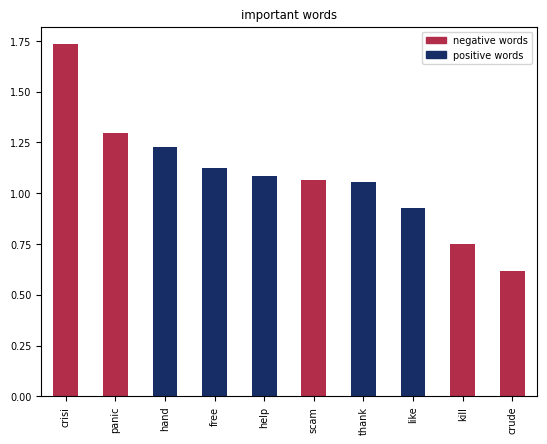

In [321]:
import matplotlib.patches as mpatches

positive = tokens_weigth[tokens_weigth > 0]
negative = tokens_weigth[tokens_weigth < 0]

top_5_positive = positive.iloc[-5:]
top_5_negative = negative.iloc[:5]

top_score = pd.DataFrame(
    data=pd.concat([top_5_positive, top_5_negative]),
    columns=["coef"]
)

top_score["is_positive"] = top_score["coef"] > 0
top_score["coef"] = top_score["coef"].abs()
top_score = top_score.sort_values("coef", ascending=False)

blue_c = "#162E65"
red_c = "#B12D49"
color_bar = np.where(top_score["is_positive"], blue_c, red_c)

red_patch = mpatches.Patch(color=red_c, label='negative words')
blue_patch = mpatches.Patch(color=blue_c, label='positive words')

ax = top_score.plot.bar(y="coef", color=color_bar, title="important words")
ax.legend(handles=[red_patch, blue_patch])

**Ответ:** Данные токены самые важные в процессе анализа и определения
тональности текста. Все они в самом деле (по субъективному мнению) отображают позитивную или негативную окраску.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

Как сказал классик, для проверки важности столбца нужно ее перемешать, если точность упала - 
признак важен. Если точность выросла, нужно задуматься... В самом деле, мы модели жить мешаем, а ей только лучше становится.

Работа тут больше не с текстом, а с категорией (имя пользователя), потому попробуем применить методы работы с категориальными признаками.

1) Label encoding
2) One-hot-кодирование
3) Счётчики (CTR, mean-target кодирование) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке

Просмотрим, сколько всего категорий имен пользователей и screenName'ов 

In [322]:
df["ScreenName"].value_counts().sort_values()

ScreenName
48752    1
48759    1
48760    1
48762    1
48763    1
        ..
89888    1
89865    1
89864    1
89825    1
89907    1
Name: count, Length: 33444, dtype: int64

In [323]:
df["UserName"].value_counts().sort_values()

UserName
3800     1
3807     1
3808     1
3810     1
3811     1
        ..
44936    1
44913    1
44912    1
44873    1
44955    1
Name: count, Length: 33444, dtype: int64

Очевидно, как категориальные оба критерия рассматривать не надо (возможно, не стоит и 
явным образом кодировать значения).

Значит, будем работать с признаками больше как текстом, а не категорией (тк,
получается, в каждой категории только одно значение).

Мы бы может и могли выявить паттерны в именах, но из-за анонимизации все что
у нас есть - числа. То есть признаки бесполезны и никак помочь нам не могут.

**Ответ:** признаки `ScreenName`, `UserName` - бесполезны

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [324]:
df.TweetAt = pd.to_datetime(df.TweetAt)
df["TweetAt"].value_counts()

TweetAt
2020-03-20    2851
2020-03-19    2644
2020-03-25    2455
2020-03-18    2256
2020-03-21    2197
2020-03-22    1733
2020-03-23    1668
2020-03-17    1616
2020-04-08    1516
2020-04-07    1469
2020-04-06    1382
2020-03-24    1196
2020-04-09    1186
2020-04-13    1157
2020-03-26    1014
2020-04-05     896
2020-04-10     766
2020-04-02     753
2020-04-11     727
2020-04-12     657
2020-04-03     656
2020-04-04     637
2020-03-16     548
2020-04-01     505
2020-03-31     274
2020-03-27     265
2020-04-14     224
2020-03-29      97
2020-03-30      77
2020-03-28      22
Name: count, dtype: int64

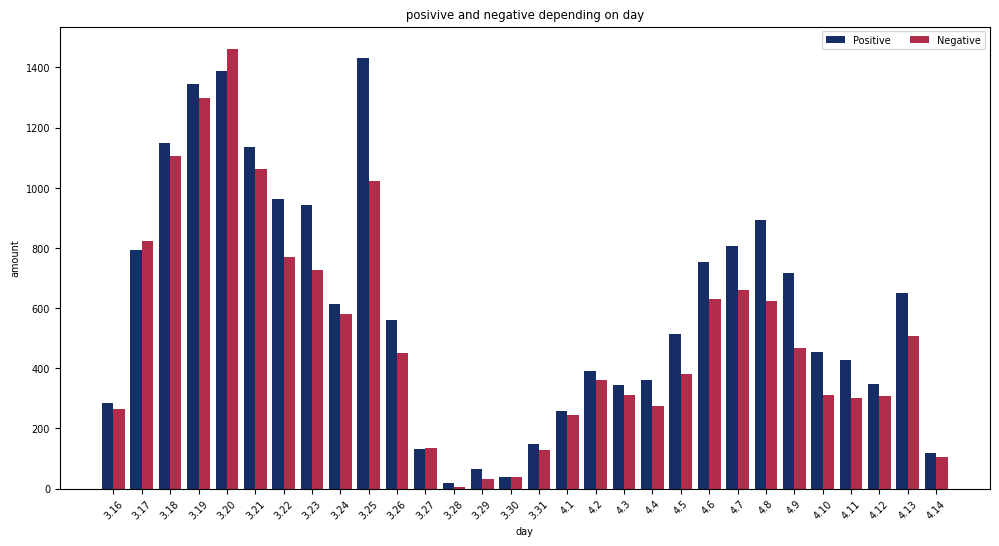

In [325]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

categories = ["positive", "negative"]
days_vc = df["TweetAt"].value_counts()
num_days = len(days_vc)

tweets_sorted = df["TweetAt"].value_counts().index.sort_values()
day_to_int = {tweets_sorted[i]: i for i in range(30)}

pos_to_days = np.zeros(num_days)
neg_to_days = np.zeros(num_days)

days = np.arange(num_days) 
width = 0.4

day_labels = [f"{x.month}.{x.day}" for x in day_to_int.keys()]

def aggregate_group(gr):
    vals_pos = gr[gr["Sentiment"] == 1]
    vals_neg = gr[gr["Sentiment"] == 0]

    day = gr["TweetAt"].iloc[0]
    day_idx = day_to_int[day]

    pos_to_days[day_idx] += vals_pos.shape[0]
    neg_to_days[day_idx] += vals_neg.shape[0]


pos_vals_to_date = df.groupby("TweetAt").apply(aggregate_group)

# Построим positive и negative колонки рядом
rects_pos = ax.bar(days - width/2, pos_to_days, width, label='Positive', color=blue_c)
rects_neg = ax.bar(days + width/2, neg_to_days, width, label='Negative', color=red_c)

ax.set_xticks(days)
ax.set_xticklabels(day_labels, rotation=45)

ax.set_ylabel('amount')
ax.set_xlabel("day")
ax.set_title('posivive and negative depending on day')

ax.legend(loc='upper right', ncols=2)

fig.show()


**Ответ:** видим, что везде примерно одинаковое число как негативных, так
и позитивных постов. Так что день недели ничего не говорит нам о вероятности выпадения положительного и негативного твита.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [326]:
locations = X_test["Location"].value_counts()
locations

Location
unknown                           2107
London, England                    139
London                             134
United States                      121
Washington, DC                      95
                                  ... 
Harris County Texas, USA             1
??? ???  ???? ??? ??????????         1
San Bernardino, CA.                  1
University of Waterloo, Canada       1
Lexington/Phoenix                    1
Name: count, Length: 3983, dtype: int64

In [327]:
locations.index

Index(['unknown', 'London, England', 'London', 'United States',
       'Washington, DC', 'United Kingdom', 'New York, NY', 'Los Angeles, CA',
       'USA', 'India',
       ...
       'Abu Dhabi', '17', 'North Lancashire', 'Marietta, Ohio',
       'Tampa Bay Area, Florida', 'Harris County Texas, USA',
       '??? ???  ???? ??? ??????????', 'San Bernardino, CA.',
       'University of Waterloo, Canada', 'Lexington/Phoenix '],
      dtype='object', name='Location', length=3983)

С этим бы хорошо поработать и удалить разыне значения, но сейчас только удалим группу 
`unknown`

In [328]:
locations = locations.drop(index=["unknown"])
locations

Location
London, England                   139
London                            134
United States                     121
Washington, DC                     95
United Kingdom                     82
                                 ... 
Harris County Texas, USA            1
??? ???  ???? ??? ??????????        1
San Bernardino, CA.                 1
University of Waterloo, Canada      1
Lexington/Phoenix                   1
Name: count, Length: 3982, dtype: int64

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

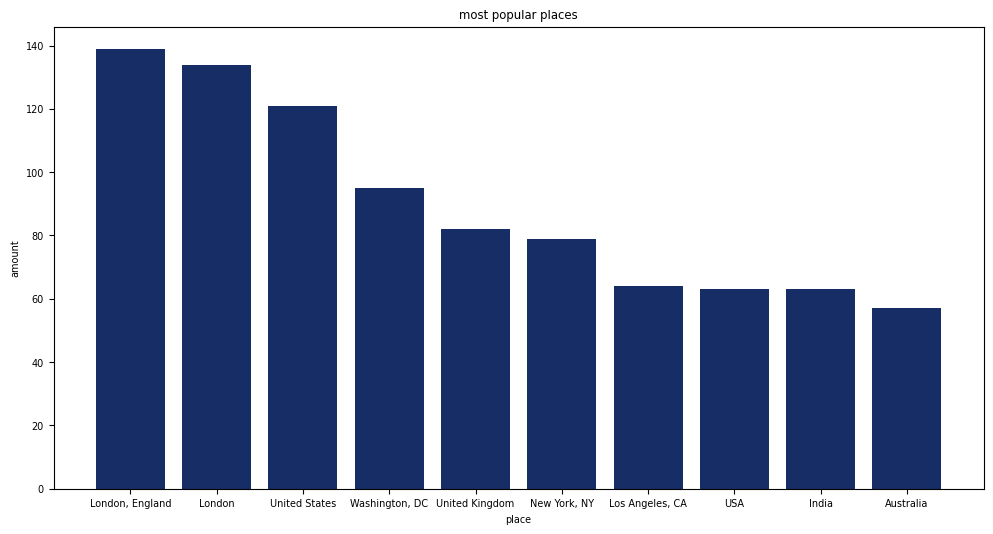

In [329]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 7})

labels = locations.head(10).index
values = locations.head(10).values

x_linspace = np.arange(len(labels)) 

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(labels, values, color=blue_c)
ax.set_ylabel('amount')
ax.set_xlabel("place")
ax.set_title('most popular places')

fig.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [330]:
display(len(X_test["Location"].value_counts()))

X_test['WiderLocation'] = (
    df['Location']
    .str.split(',') 
    .str[-1]  
    .str.split()
    .apply(lambda x:       # а тут добавил такое
           x[0]
           if len(x) == 1  # если пункт из одного слова - пусть
           else "".join(w[0].upper() for w in x)  # если слов много, сделай join их первых букв
    )
)

X_train['WiderLocation'] = (
    df['Location']
    .str.split(',') 
    .str[-1]  
    .str.split()
    .apply(lambda x:
           x[0]
           if len(x) == 1
           else "".join(w[0].upper() for w in x)
    )
)


len(X_test["WiderLocation"].value_counts())

3983

1983

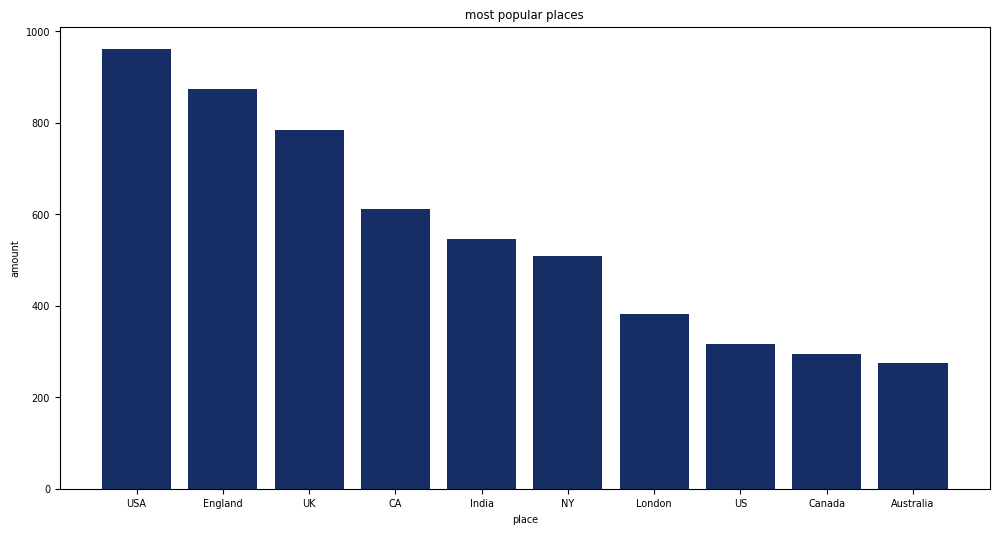

In [331]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 7})

locations_wider = X_train["WiderLocation"].value_counts()
locations_wider = locations_wider.drop(index=["unknown"])


labels = locations_wider.head(10).index
values = locations_wider.head(10).values

x_linspace = np.arange(len(labels)) 

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(labels, values, color=blue_c)
ax.set_ylabel('amount')
ax.set_xlabel("place")
ax.set_title('most popular places')

fig.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [332]:
display(locations_wider.shape[0])
wider_more_1 = locations_wider[locations_wider > 1]
wider_more_1.shape[0]

3722

1075

In [333]:
wider_more_1

WiderLocation
USA         962
England     873
UK          784
CA          611
India       547
           ... 
illinois      2
Woolwich      2
LE            2
P1            2
##B           2
Name: count, Length: 1075, dtype: int64

Мало, в общем, таких мест, откуда больше одного раза писали.

In [334]:
X_train["WiderLocation"].isin(wider_more_1.index)

25621    False
30135     True
28899     True
5989      True
4367     False
         ...  
20757    False
32103     True
30403     True
21243    False
2732     False
Name: WiderLocation, Length: 23410, dtype: bool

In [335]:
X_train.shape

(23410, 6)

In [336]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
to_fit_ohe = X_train[X_train["WiderLocation"].isin(wider_more_1.index)]
ohe.fit(to_fit_ohe[["WiderLocation"]])

X_test_loc_ohe = ohe.transform(X_test[["WiderLocation"]]).toarray()
X_test_loc_ohe = pd.DataFrame(data=X_test_loc_ohe, columns=ohe.get_feature_names_out())

X_train_loc_ohe = ohe.transform(X_train[["WiderLocation"]]).toarray()
display(X_train_loc_ohe.shape)
X_train_loc_ohe = pd.DataFrame(data=X_train_loc_ohe, columns=ohe.get_feature_names_out())

X_train = pd.concat([X_train, X_test_loc_ohe], axis=1)
X_train.columns

(23410, 1075)

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'WiderLocation', 'WiderLocation_', 'WiderLocation_##',
       'WiderLocation_###', 'WiderLocation_##B',
       ...
       'WiderLocation_tx', 'WiderLocation_uk', 'WiderLocation_up',
       'WiderLocation_usa', 'WiderLocation_washington', 'WiderLocation_world',
       'WiderLocation_worldwide', 'WiderLocation_y'all',
       'WiderLocation_||somali|kenyan??', 'WiderLocation_ÃÂ¯\_(?)_/ÃÂ¯'],
      dtype='object', length=1081)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [345]:
train_normed.toarray().shape, X_train_loc_ohe.shape

((23410, 3694), (23410, 1075))

In [346]:
test_normed.toarray().shape, X_test_loc_ohe.shape

((10034, 3694), (10034, 1075))

In [356]:
lr = LogisticRegression()
train_normed_ohe = np.concatenate([train_normed.toarray(), X_train_loc_ohe.values], axis=1)
test_normed_ohe = np.concatenate([test_normed.toarray(), X_test_loc_ohe.values], axis=1)
lr.fit(train_normed_ohe, y_train)

train_pred = lr.predict(train_normed_ohe)
test_pred = lr.predict(test_normed_ohe)

data_stem_accuracy = {
    "train": accuracy_score(train_pred, y_train),
    "test": accuracy_score(test_pred, y_test),
}

pd.Series(data_stem_accuracy)

train    0.944169
test     0.844429
dtype: float64

In [357]:
# было
data_ans

train    0.941521
test     0.843731
dtype: float64

**Ответ:** нет, геолокация ничего не дает о позитиве или негативе поста,
так как разницы скоринга в пределах процентной единицы.

**НА ЭТОМ ВСЕ**

А вот видосик для настроения (написан из 16 мая)

In [ ]:
https://www.youtube.com/shorts/PWKqOxC9a1E

а вообще нереально долго копаться в документации, пытаться понять почему не сходятся размерности массивов, почему числа разные из прошлых логов, почему качество моделей иногда вообще падает. документации и эти графики тоже хлопот доставляют. тяжело все это. короче, хочу еще :)))